In [15]:
import pandas as pd
import numpy as np
import plotly.express as px
from collections import defaultdict
from datetime import date, timedelta
from sklearn import metrics
from utils import get_state_error_df, get_predictions_df

In [7]:
labels = pd.read_csv('election_data/final_results_by_state.csv')
battleground_df = pd.read_csv('pop_data/2016_pres_labels_battleground.csv')[['state_po', 'battleground']]

In [8]:
d_probs = pd.read_csv('poll_data/all_pres_polls_d_probs.csv')

In [9]:
start_date = '2020-05-01'
end_dates = list(map(lambda day: str((date(2020, 11, 3) - timedelta(day))), [3, 50, 100]))

In [10]:
models = {
    'logistic_04': {'alpha': 0.4, 'logistic': True},
    'lambda_02': {'alpha': 0.2, 'logistic': False},
    'lambda_1': {'alpha': 1, 'logistic': False},
}

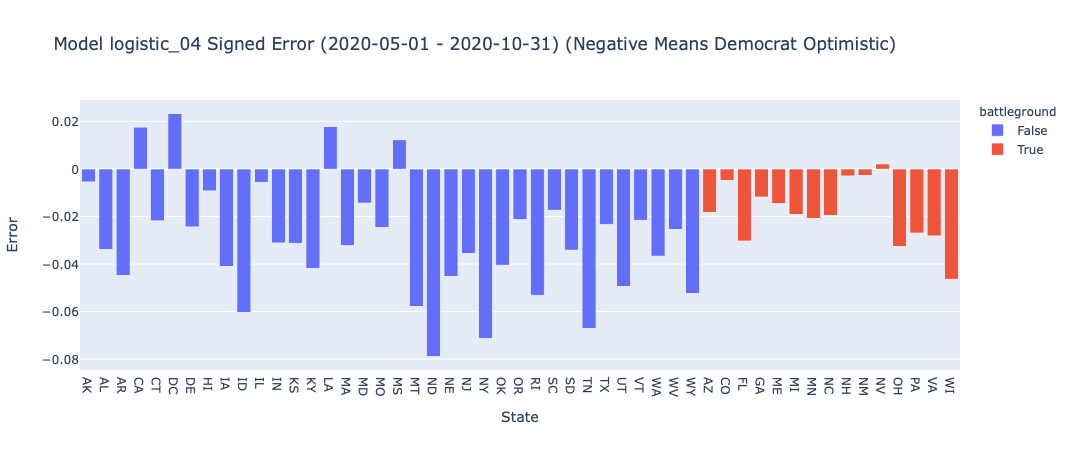

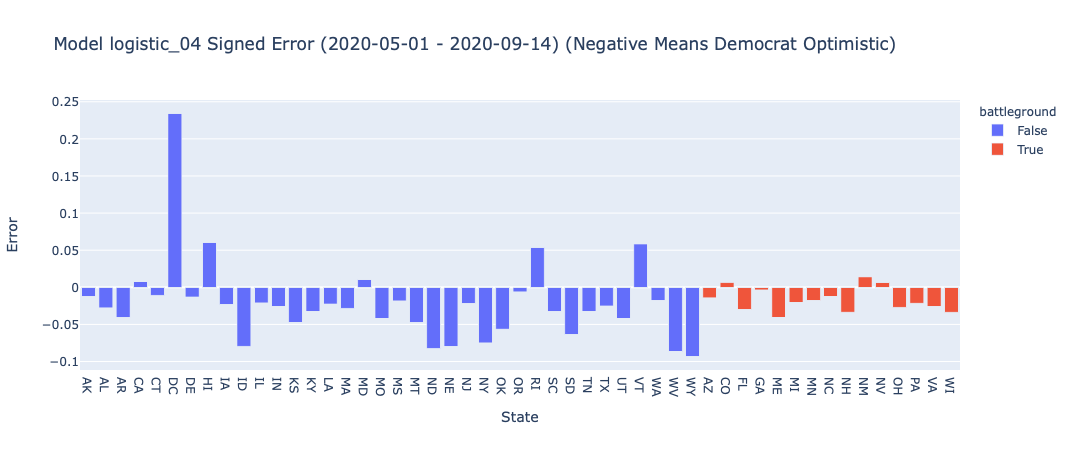

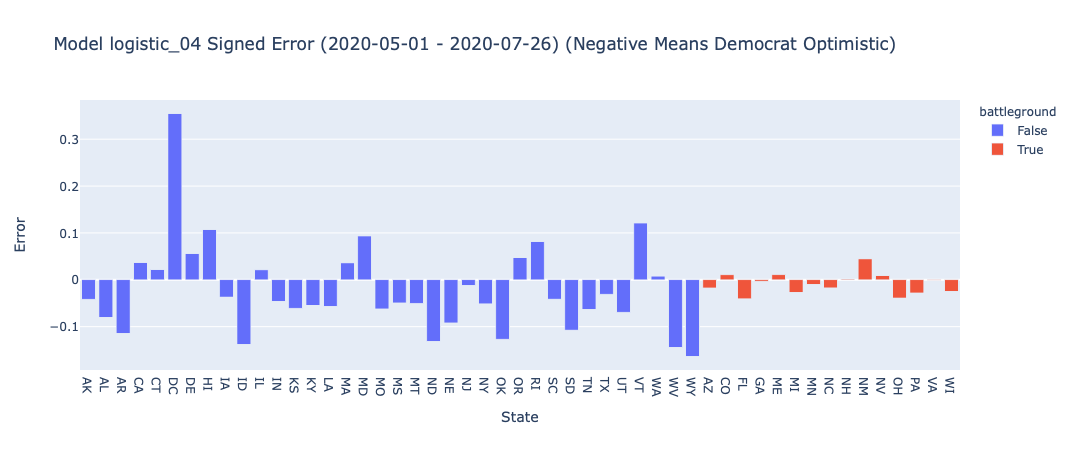

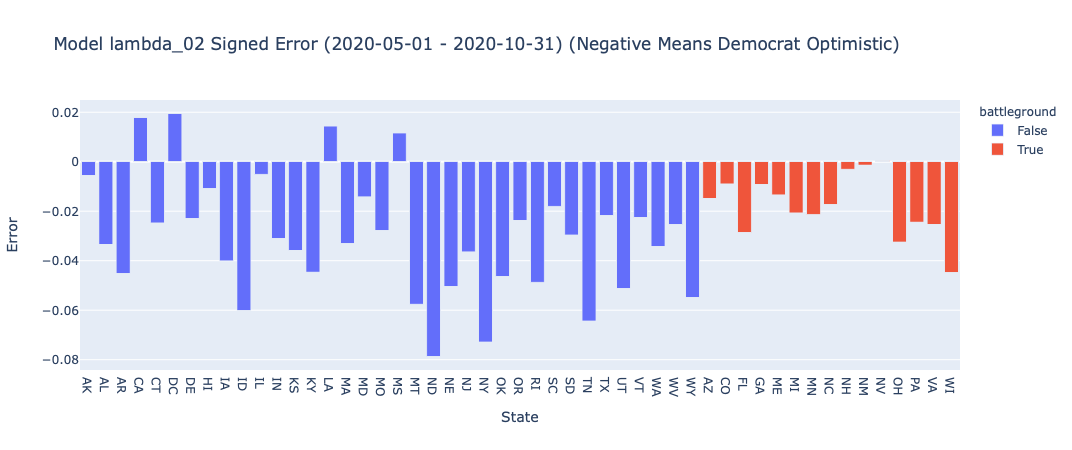

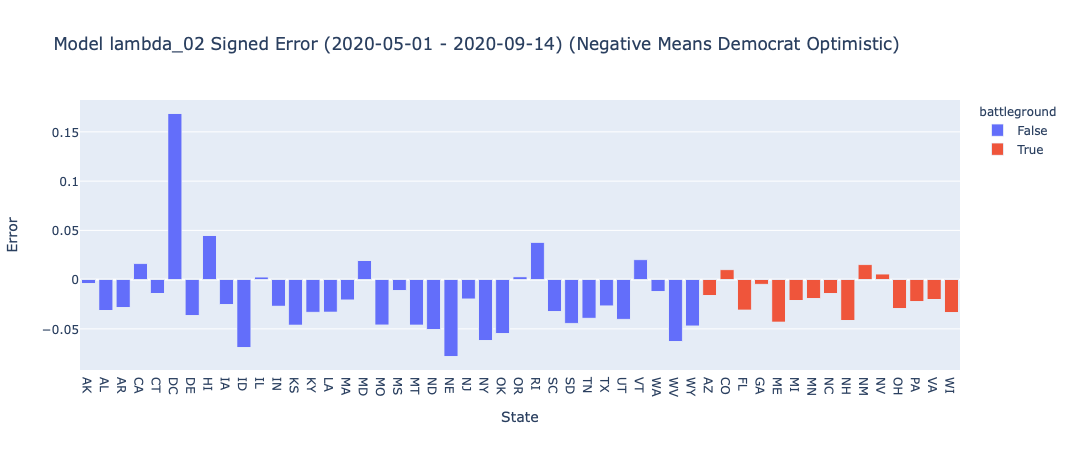

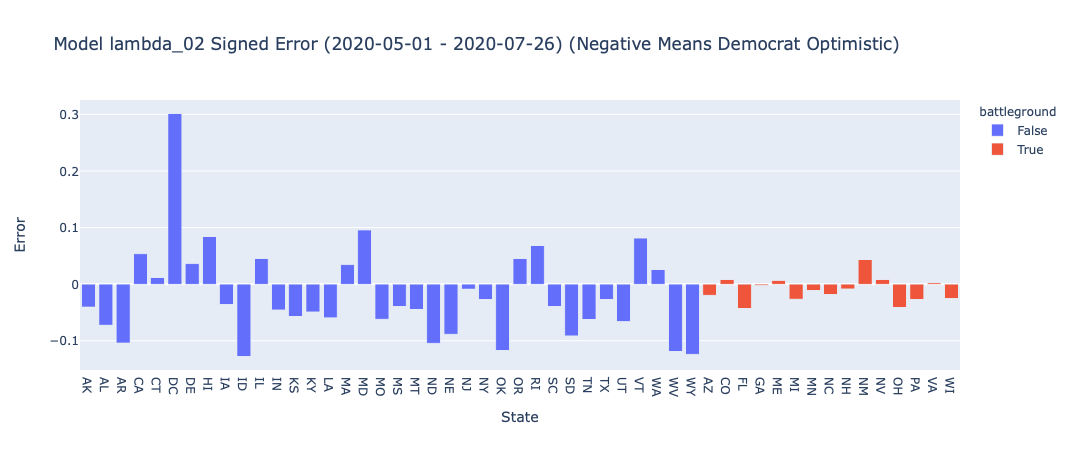

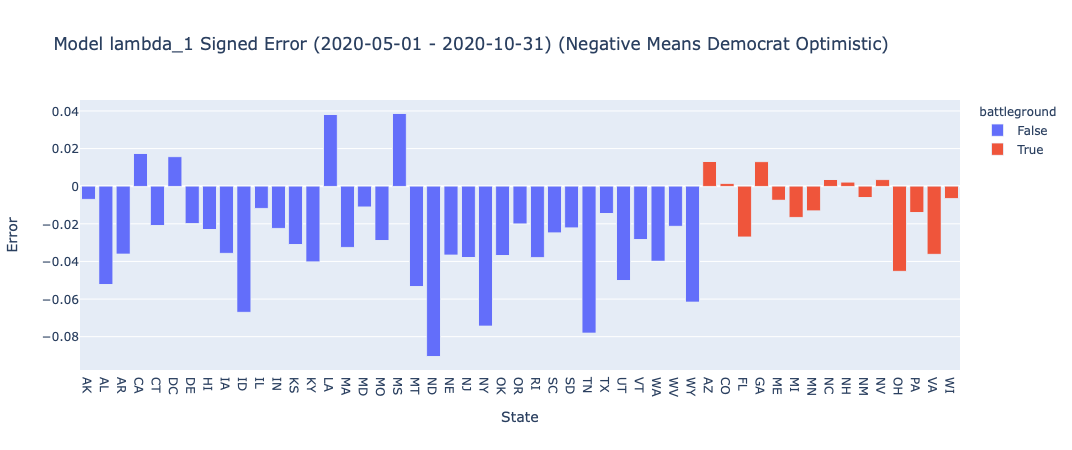

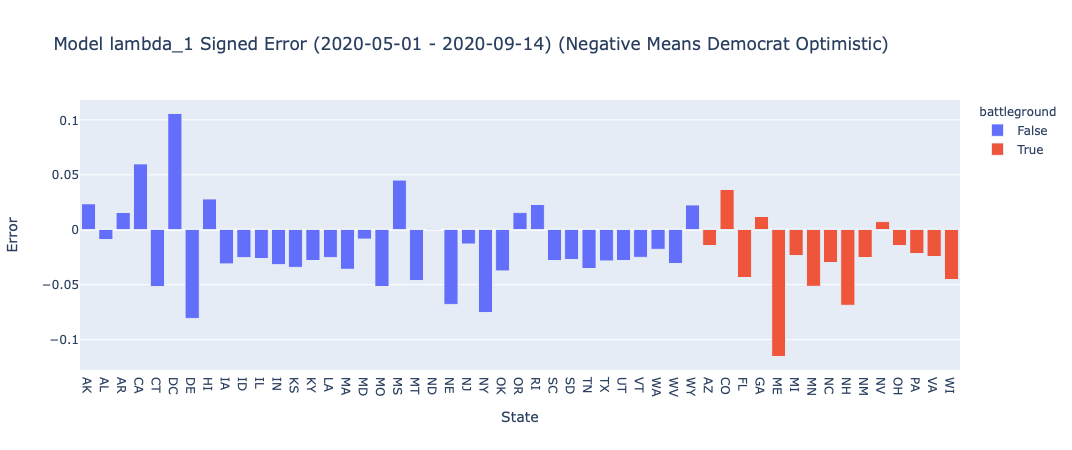

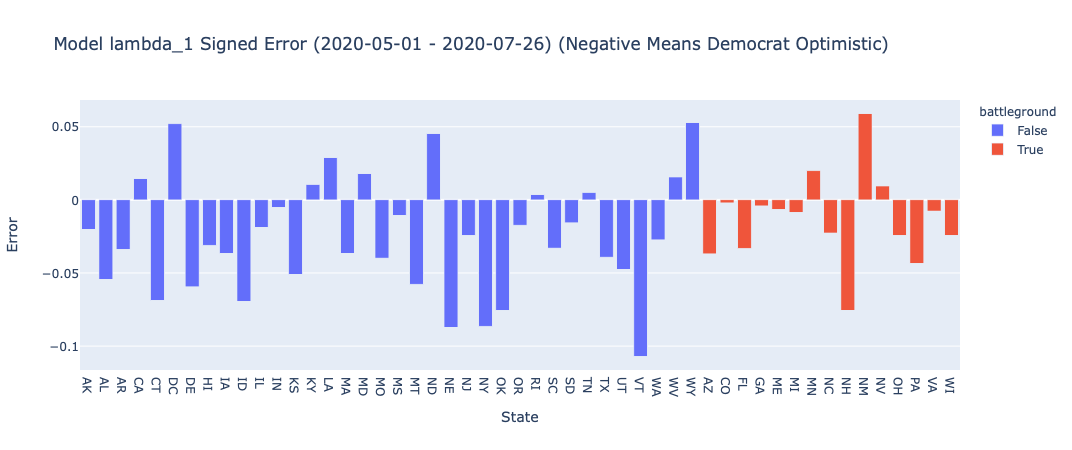

In [52]:
model_errors = list()
for model in models:
    for end_date in end_dates:
        preds = get_predictions_df(d_probs, **models[model], start_date=start_date, end_date=end_date)
        model_er = pd.merge(get_state_error_df(labels, preds), battleground_df).sort_values(by=['battleground', 'state_po'])
        battleground_err = np.mean(model_er[model_er['battleground']]['error'])
        non_battleground_err = np.mean(model_er[~model_er['battleground']]['error'])
        model_errors.append((model, end_date, True, battleground_err))
        model_errors.append((model, end_date, False, non_battleground_err))
        fig = px.bar(model_er, x='state_po', y='error', color='battleground',
                     labels={'error': 'Error', 'state_po': 'State'}, 
                     title=f'Model {model} Signed Error ({start_date} - {end_date}) (Negative Means Democrat Optimistic)')
        filename = f'{model}_{start_date}-{end_date}_signed_error'
        fig.show()
        fig.write_image(f'figures/{filename}.png')
        model_er.to_csv(f'figures/data/{filename}.csv', index=False)

In [54]:
df = pd.DataFrame(model_errors, columns=['model', 'end_date', 'battleground', 'error'])

In [63]:
fig = px.line(df[~df['battleground']], x="end_date", y="error", color="model",
              labels={'end_date': 'Prediction Date', 'error': 'Signed Error'},
             title='Non-battleground State Signed Error (Negative Means Democrat Optimistic)')
# fig.show()
filename = f'figures/signed_error_non_battleground_time_series.png'
fig.write_image(filename)
df[~df['battleground']].to_csv('figures/data/signed_error_non_battleground_time_series.csv', index=False)

In [64]:
fig = px.line(df[df['battleground']], x="end_date", y="error", color="model",
              labels={'end_date': 'Prediction Date', 'error': 'Signed Error'},
             title='Battleground State Signed Error (Negative Means Democrat Optimistic)')
# fig.show()
filename = f'figures/signed_error_battleground_time_series.png'
df[df['battleground']].to_csv('figures/data/signed_error_battleground_time_series.csv', index=False)
fig.write_image(filename)

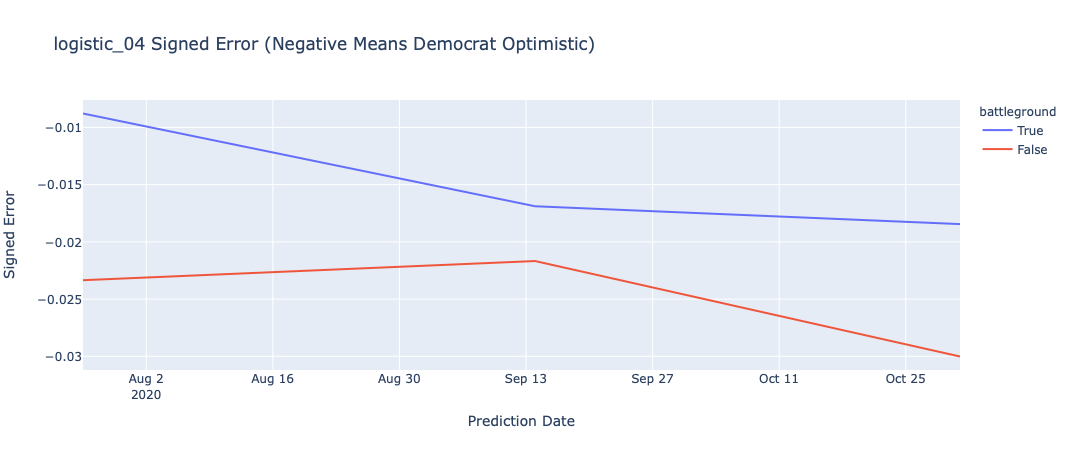

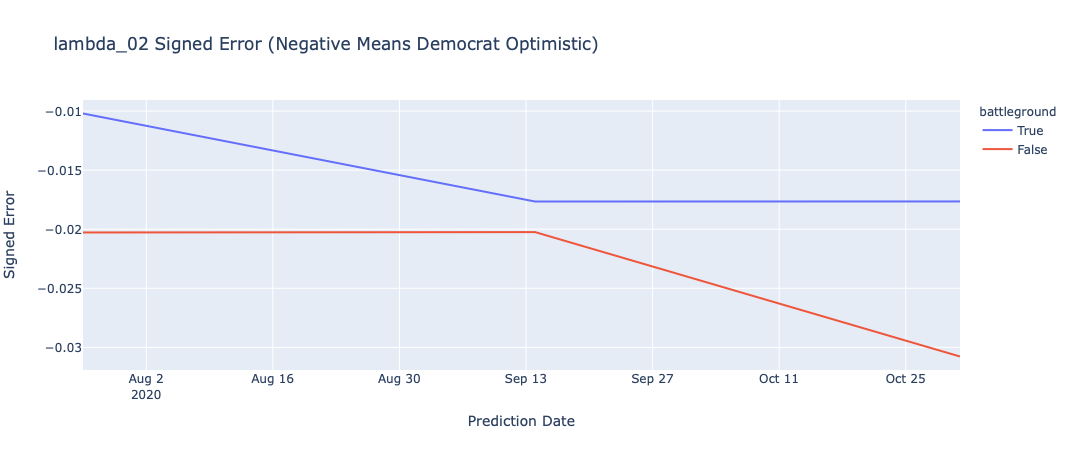

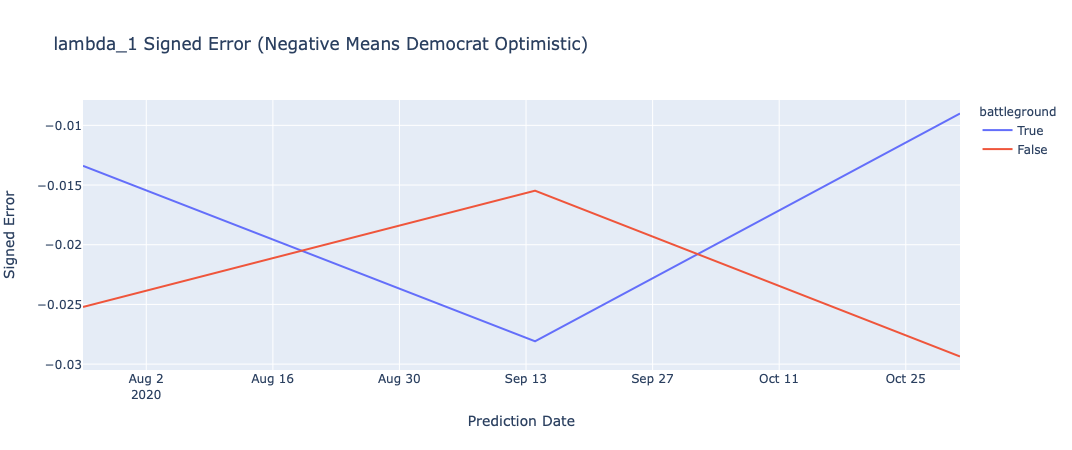

In [67]:
for model in models:
    fig = px.line(df[df['model'] == model], x="end_date", y="error", color="battleground",
                  labels={'end_date': 'Prediction Date', 'error': 'Signed Error'},
                 title=f'{model} Signed Error (Negative Means Democrat Optimistic)')
    fig.show()
    filename = f'figures/{model}_signed_error_time_series.png'
    fig.write_image(filename)
    df[df['model'] == model].to_csv('figures/data/_signed_error_time_series.csv', index=False)